TTC Delay Predictor (Team 14) Project Source Code
Goal: Develop a machine learning regression model to predict the average subway delay (in minutes) using historical TTC subway delay data.
Scope: Analyze factors such as time of day, station location, and train line to uncover trends and improve predictions.
Source of Data: https://open.toronto.ca/dataset/ttc-subway-delay-data/

In [75]:
# Importing Necessary Libraries
# # Data Handling Libraries
import pandas as pd
import numpy as np
import os
import glob
# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Feature Engineering Libraries
from datetime import datetime
# Machine Learning Models Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
# Model Evaluation Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Data Collection and Exploration

In [76]:
# Data Acquisition

# GitHub Raw File URL (Updated)
url = "https://raw.githubusercontent.com/ceejay868/Team-14/main/data/combined/ttc-subway-delay-data.csv"

# Load dataset with CSV UTF-8 encoding
try:
    df = pd.read_csv(url, encoding="utf-8")
    print(f"Successfully Loaded Dataset from GitHub!")
    print(f"Dataset Shape: {df.shape}")
    print("\nFirst 5 Rows:")
    print(df.head())
except Exception as e:
    print(f"Failed to Load Dataset: {e}")

Successfully Loaded Dataset from GitHub!
Dataset Shape: (211913, 10)

First 5 Rows:
         Date  Time        Day                Station   Code  Min Delay  \
0  2014-01-01  0:21  Wednesday  VICTORIA PARK STATION  MUPR1       55.0   
1  2014-01-01  2:06  Wednesday      HIGH PARK STATION   SUDP        3.0   
2  2014-01-01  2:40  Wednesday       SHEPPARD STATION  MUNCA        0.0   
3  2014-01-01  3:10  Wednesday      LANSDOWNE STATION   SUDP        3.0   
4  2014-01-01  3:20  Wednesday          BLOOR STATION  MUSAN        5.0   

   Min Gap Bound Line  Vehicle  
0     60.0     W   BD   5111.0  
1      7.0     W   BD   5001.0  
2      0.0   NaN   YU      0.0  
3      8.0     W   BD   5116.0  
4     10.0     S   YU   5386.0  


C:\Users\ifara\AppData\Local\Temp\ipykernel_9712\3035237457.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings


Missing values detected as follows:

Min Delay     1296
Min Gap       1341
Bound        56129
Line           678
Vehicle        817


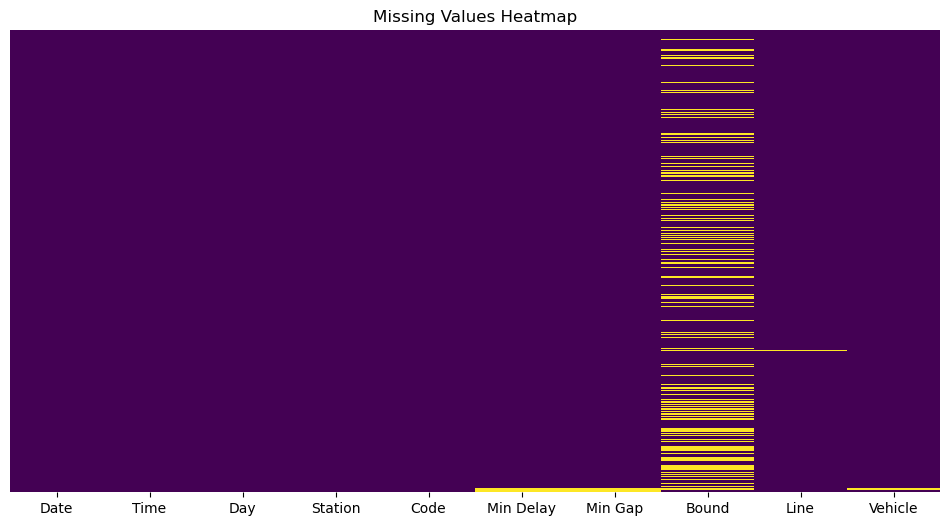

In [77]:
# Check for Missing Values

# Checking for missing values: null, empty cells, and 'n/a' strings
missing_values = df.isnull().sum()  # Standard missing values (NaN)
empty_values = (df == "").sum()  # Empty strings
na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings

# Combining all missing value checks
total_missing = missing_values + empty_values + na_values

# Displaying only columns with missing data
total_missing = total_missing[total_missing > 0]

# Print results in a clean format
if total_missing.empty:
    print("No missing values found in the dataset!")
else:
    print("Missing values detected as follows:\n")
    print(total_missing.to_string())

# Visualizing missing values using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [78]:
# Deal with Missing Values

# Dropping rows where the "Bound" column has missing values
df_cleaned = df.dropna()

# Displaying the shape before and after removing missing values
print(f"Original dataset shape: {df.shape}")
print(f"Dataset shape after removing rows with missing 'Bound': {df_cleaned.shape}")
print(f"Total rows removed: {df.shape[0] - df_cleaned.shape[0]}")

# Updating the dataset to use the cleaned version
df = df_cleaned

# Display the first few rows to confirm
df.head()


Original dataset shape: (211913, 10)
Dataset shape after removing rows with missing 'Bound': (155055, 10)
Total rows removed: 56858


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,0:21,Wednesday,VICTORIA PARK STATION,MUPR1,55.0,60.0,W,BD,5111.0
1,2014-01-01,2:06,Wednesday,HIGH PARK STATION,SUDP,3.0,7.0,W,BD,5001.0
3,2014-01-01,3:10,Wednesday,LANSDOWNE STATION,SUDP,3.0,8.0,W,BD,5116.0
4,2014-01-01,3:20,Wednesday,BLOOR STATION,MUSAN,5.0,10.0,S,YU,5386.0
5,2014-01-01,3:29,Wednesday,DUFFERIN STATION,MUPAA,0.0,0.0,E,BD,5174.0


C:\Users\ifara\AppData\Local\Temp\ipykernel_9712\3538717857.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings


No missing values found in the dataset after cleaning


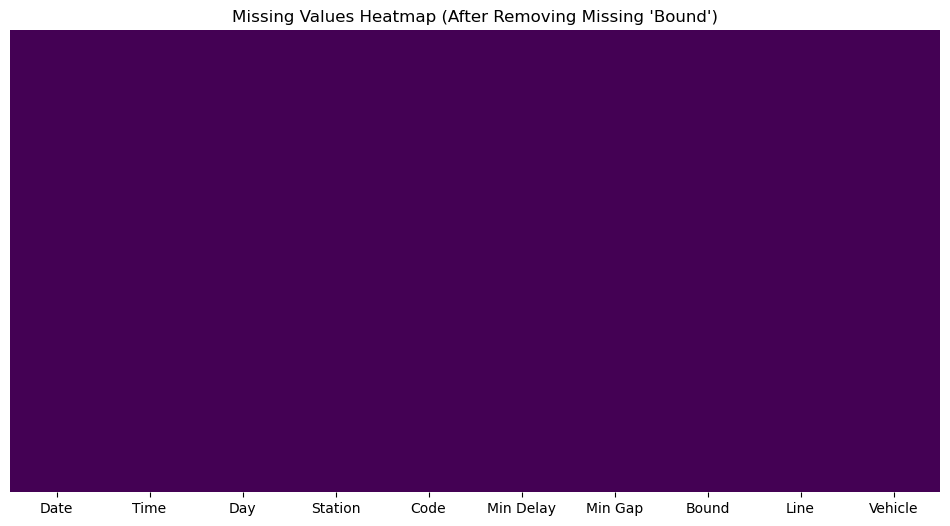

In [79]:
# Re-Check for Missing Values

# Checking for missing values: null, empty cells, and 'n/a' strings
missing_values = df.isnull().sum()  # Standard missing values (NaN)
empty_values = (df == "").sum()  # Empty strings
na_values = (df.applymap(lambda x: str(x).strip().lower() == 'n/a')).sum()  # 'n/a' strings

# Combining all missing value checks
total_missing = missing_values + empty_values + na_values

# Displaying only columns with missing data
total_missing = total_missing[total_missing > 0]

# Printing results
if total_missing.empty:
    print("No missing values found in the dataset after cleaning")
else:
    print("Missing values detected after cleaning:\n")
    print(total_missing.to_string())

# Visualizing missing values using a heatmap after cleaning
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap (After Removing Missing 'Bound')")
plt.show()


In [80]:
# Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Total duplicate rows in the dataset: {duplicate_rows}")


Total duplicate rows in the dataset: 90


In [81]:
# Removing duplicate rows from the dataset
df = df.drop_duplicates()

# Printing the updated dataset shape after removing duplicates
print(f"Dataset shape after removing duplicates: {df.shape}")

df.head()

Dataset shape after removing duplicates: (154965, 10)


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,0:21,Wednesday,VICTORIA PARK STATION,MUPR1,55.0,60.0,W,BD,5111.0
1,2014-01-01,2:06,Wednesday,HIGH PARK STATION,SUDP,3.0,7.0,W,BD,5001.0
3,2014-01-01,3:10,Wednesday,LANSDOWNE STATION,SUDP,3.0,8.0,W,BD,5116.0
4,2014-01-01,3:20,Wednesday,BLOOR STATION,MUSAN,5.0,10.0,S,YU,5386.0
5,2014-01-01,3:29,Wednesday,DUFFERIN STATION,MUPAA,0.0,0.0,E,BD,5174.0


In [82]:
# Re-Check for duplicate rows in the dataset
duplicate_rows = df.duplicated().sum()

# Print the number of duplicate rows
print(f"Total duplicate rows in the dataset: {duplicate_rows}")

Total duplicate rows in the dataset: 0


In [83]:
# Ensure Correct Data Types

# Converting "Date" column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

# Converting "Time" column to proper time format
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M", errors="coerce").dt.time

# Ensuring "Day" is a string and has valid values
df["Day"] = df["Day"].astype(str).str.strip()

# Ensuring categorical columns are strings
categorical_columns = ["Station", "Code", "Bound", "Line", "Vehicle"]
for col in categorical_columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Ensuring "Min Delay" and "Min Gap" are numeric
df["Min Delay"] = pd.to_numeric(df["Min Delay"], errors="coerce")
df["Min Gap"] = pd.to_numeric(df["Min Gap"], errors="coerce")

# Display data types to confirm changes
print(df.dtypes)

C:\Users\ifara\AppData\Local\Temp\ipykernel_9712\3235232287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
C:\Users\ifara\AppData\Local\Temp\ipykernel_9712\3235232287.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Time"] = pd.to_datetime(df["Time"], format="%H:%M", errors="coerce").dt.time
C:\Users\ifara\AppData\Local\Temp\ipykernel_9712\3235232287.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy o

Date         datetime64[ns]
Time                 object
Day                  object
Station              object
Code                 object
Min Delay           float64
Min Gap             float64
Bound                object
Line                 object
Vehicle              object
dtype: object


C:\Users\ifara\AppData\Local\Temp\ipykernel_9712\3235232287.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(str).str.strip().str.lower()
C:\Users\ifara\AppData\Local\Temp\ipykernel_9712\3235232287.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Min Delay"] = pd.to_numeric(df["Min Delay"], errors="coerce")
C:\Users\ifara\AppData\Local\Temp\ipykernel_9712\3235232287.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [85]:
# Check for Inconsistent Values

# Identify unique values in categorical columns to check for inconsistencies
for col in ["Day", "Station", "Code", "Bound", "Line"]:
    print(f"Unique values in '{col}': {df[col].unique()}")


Unique values in 'Day': ['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']
Unique values in 'Station': ['victoria park station' 'high park station' 'lansdowne station'
 'bloor station' 'dufferin station' 'kipling station' 'yonge shp station'
 'st patrick station' 'kennedy bd station' 'jane station'
 'old mill station' 'sheppard west station' 'bay station' 'finch station'
 'coxwell station' 'st clair west station' 'north york ctr station'
 'queen station' 'dupont station' 'york mills station' 'osgoode station'
 'college station' 'yonge bd station' 'st george yus station'
 'mccowan station' 'eglinton station' 'broadview station'
 'rosedale station' 'pape station' 'greenwood station'
 'lawrence east station' 'kennedy srt station' 'islington station'
 'warden station' 'davisville station' 'lawrence station'
 'eglinton west station' 'keele station' 'midland station'
 'ellesmere station' 'union station' 'chester station' 'glencairn station'
 'wilson station' 'yorkdale s

In [87]:
# Bounds 5, R, Y, B are invalid values per TTC so we will remove them

# Storing the original dataset size before removal
original_shape = df.shape

# Defining invalid "Bound" values
invalid_bounds = ["5", "r", "y", "b"]

# Remove rows where "Bound" contains invalid values
df_cleaned = df[~df["Bound"].isin(invalid_bounds)]

# Storing the new dataset size after removal
new_shape = df_cleaned.shape

# Printing dataset size before and after removal
print(f"Original dataset shape: {original_shape}")
print(f"Dataset shape after removing invalid 'Bound' values: {new_shape}")
print(f"Total rows removed: {original_shape[0] - new_shape[0]}")

# Updating the dataset
df = df_cleaned

Original dataset shape: (154654, 10)
Dataset shape after removing invalid 'Bound' values: (154654, 10)
Total rows removed: 0


In [88]:
# The "Line" column has names that do not follow the standard of TTC and they need to be re-mapped as below:   
#(i) 'yus'	need to be re-labelled to 'yu'	
#(ii) 'line 1'	needs to be re-labelled to 'yu'
#(iii) 'bloor danforth'	needs to be re-labelled to 'bd'
#(iv) 'rt'	needs to be re-labelled to 'srt'

#Additionally, "Line" column with value of 'yu/bd' and 'yus & bd' is a combination of two subway lines and these rows should be removed

# Storing original dataset size before modifications
original_shape = df.shape

# Defining mapping for standardizing "Line" column
line_mapping = {
    "yus": "yu",
    "line 1": "yu",
    "bloor danforth": "bd",
    "rt": "srt"
}

# Applying the mapping to standardize line names
df["Line"] = df["Line"].replace(line_mapping)

# Removing rows where "Line" contains combined subway lines ('yu/bd' and 'yus & bd')
df_cleaned = df[~df["Line"].isin(["yu/bd", "yus & bd"])]

# Storing new dataset size after removal
new_shape = df_cleaned.shape

# Printing the number of rows removed
rows_removed = original_shape[0] - new_shape[0]
print(f"'Line' column is standardized per TTC.")
print(f"Removed rows where 'Line' contained combined subway lines ('yu/bd', 'yus & bd').")
print(f"Total rows removed: {rows_removed}")
print(f"Updated dataset shape: {new_shape}")

# Updating the dataset
df = df_cleaned


'Line' column is standardized per TTC.
Removed rows where 'Line' contained combined subway lines ('yu/bd', 'yus & bd').
Total rows removed: 4
Updated dataset shape: (154650, 10)


In [120]:
# Ensuring 'Station' column has correct labels
# There were a number of incorrect/unwanted values in the 'Station' column that need to be removed (not a subway station/bus station i.e., train yard)

import re
# List of unwanted substrings to remove if they appear in "Station" (case insensitive)
unwanted_patterns = [
    r"\(", "- l", "to", "failure", "atc", "system", "via", "e13", "yard", "track",
    "zone", "and b", "- mig", "yus line", "line 1 yus", "towards", "migration", "-",
    "south bound south of l", "pocket", "line", "wilson hostler", "platform",
    "all stations", "from", "approaching", "exit", "leaving", "portal", "wye", "emergency",
    "power", "carhouse", "car house", "carhouse lead",
    "lower", "portal", "centre", "control", "migratio", "yus/bd/sheppard subway", "division",
    "hoslter", "of", "building", "build up", "rapid", "trac", "departin", "\[", "approac", "tail"
]

# Store original dataset size before removal
original_shape = df.shape

# Create regex pattern for matching unwanted values
pattern_regex = "|".join([rf"{p}" for p in unwanted_patterns])

# Count occurrences of unwanted patterns in "Station" column before removal
unwanted_counts = df["Station"].str.contains(pattern_regex, case=False, na=False, regex=True).sum()

# Print count of unwanted occurrences before removal
print(f"Total occurrences of unwanted patterns in 'Station' before removal: {unwanted_counts}")

# Remove rows where "Station" contains any of the unwanted patterns
df_cleaned = df[~df["Station"].str.contains(pattern_regex, case=False, na=False, regex=True)]

# Store new dataset size after removal
new_shape = df_cleaned.shape

# Calculate number of rows removed
rows_removed = original_shape[0] - new_shape[0]

# Print number of rows removed
print(f"Removed rows where 'Station' contained specified unwanted text.")
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

# Update the dataset
df = df_cleaned




Total occurrences of unwanted patterns in 'Station' before removal: 3
Removed rows where 'Station' contained specified unwanted text.
Total rows removed: 3
Original dataset shape: (135749, 17)
Updated dataset shape: (135746, 17)


In [121]:
# Re-Check for Inconsistent Values
for col in ["Day", "Station", "Code", "Bound", "Line"]:
    print(f"Unique values in '{col}': {df[col].unique()}")


Unique values in 'Day': ['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']
Unique values in 'Station': ['high park station' 'lansdowne station' 'bloor station'
 'dufferin station' 'kipling station' 'yonge shp station'
 'st patrick station' 'kennedy bd station' 'jane station'
 'old mill station' 'sheppard west station' 'bay station' 'finch station'
 'coxwell station' 'st clair west station' 'north york ctr station'
 'queen station' 'dupont station' 'york mills station' 'osgoode station'
 'college station' 'yonge bd station' 'st george yus station'
 'mccowan station' 'broadview station' 'rosedale station' 'pape station'
 'greenwood station' 'lawrence east station' 'kennedy srt station'
 'warden station' 'davisville station' 'lawrence station' 'keele station'
 'midland station' 'ellesmere station' 'union station' 'chester station'
 'glencairn station' 'wilson station' 'yorkdale station' 'museum station'
 'davisville hostler' 'leslie station' 'dundas station'
 'sherbo

In [123]:
# Additional Station Columns Clean-up
# Station/stn is not an actual stop and does not reperesent any valuable information. We will remove these rows

# Store original dataset size before removal
original_shape = df.shape

# Count occurrences of "station" and "stn" before removal
invalid_station_count = df["Station"].str.lower().isin(["station", "stn"]).sum()

# Print count before removal
print(f"Total occurrences of 'Station' column containing only 'station' or 'stn' before removal: {invalid_station_count}")

# Remove rows where "Station" is exactly "station" or "stn"
df_cleaned = df[~df["Station"].str.lower().isin(["station", "stn"])]

# Store new dataset size after removal
new_shape = df_cleaned.shape

# Calculate number of rows removed
rows_removed = original_shape[0] - new_shape[0]

# Print number of rows removed
print(f"Removed rows where 'Station' was exactly 'station' or 'stn'.")
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

# Update the dataset
df = df_cleaned

Total occurrences of 'Station' column containing only 'station' or 'stn' before removal: 1
Removed rows where 'Station' was exactly 'station' or 'stn'.
Total rows removed: 1
Original dataset shape: (135746, 17)
Updated dataset shape: (135745, 17)


In [124]:
# Get unique values from the "Station" column
unique_stations = df["Station"].unique()

# Convert to a DataFrame for easy viewing
station_df = pd.DataFrame(unique_stations, columns=["Station"])

# Print the unique station names
print("Unique station names in the dataset:")
print(station_df.to_string(index=False))

Unique station names in the dataset:
               Station
     high park station
     lansdowne station
         bloor station
      dufferin station
       kipling station
     yonge shp station
    st patrick station
    kennedy bd station
          jane station
      old mill station
 sheppard west station
           bay station
         finch station
       coxwell station
 st clair west station
north york ctr station
         queen station
        dupont station
    york mills station
       osgoode station
       college station
      yonge bd station
 st george yus station
       mccowan station
     broadview station
      rosedale station
          pape station
     greenwood station
 lawrence east station
   kennedy srt station
        warden station
    davisville station
      lawrence station
         keele station
       midland station
     ellesmere station
         union station
       chester station
     glencairn station
        wilson station
      yorkdale stati

In [125]:
# Checking Code Column for Inconsistencies
# It has "XXXXX" values which are invalid and
# need to be removed from the dataset

# Count occurrences of "XXXXX" in the "Code" column before removal
xxxxx_count = df["Code"].str.upper().eq("XXXXX").sum()

# Print the count before removal
print(f"Total occurrences of 'XXXXX' in 'Code' before removal: {xxxxx_count}")

# Store original dataset size before removal
original_shape = df.shape

# Remove rows where "Code" is exactly "XXXXX" (case insensitive)
df_cleaned = df[~df["Code"].str.upper().eq("XXXXX")]

# Store new dataset size after removal
new_shape = df_cleaned.shape

# Print the number of rows removed
rows_removed = original_shape[0] - new_shape[0]
print(f"Removed rows where 'Code' was 'XXXXX'.")
print(f"Total rows removed: {rows_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

# Update the dataset
df = df_cleaned


Total occurrences of 'XXXXX' in 'Code' before removal: 0
Removed rows where 'Code' was 'XXXXX'.
Total rows removed: 0
Original dataset shape: (135745, 17)
Updated dataset shape: (135745, 17)


In [126]:
# Re-Check for Inconsistent Values
for col in ["Day", "Station", "Code", "Bound", "Line"]:
    print(f"Unique values in '{col}': {df[col].unique()}")

Unique values in 'Day': ['Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday']
Unique values in 'Station': ['high park station' 'lansdowne station' 'bloor station'
 'dufferin station' 'kipling station' 'yonge shp station'
 'st patrick station' 'kennedy bd station' 'jane station'
 'old mill station' 'sheppard west station' 'bay station' 'finch station'
 'coxwell station' 'st clair west station' 'north york ctr station'
 'queen station' 'dupont station' 'york mills station' 'osgoode station'
 'college station' 'yonge bd station' 'st george yus station'
 'mccowan station' 'broadview station' 'rosedale station' 'pape station'
 'greenwood station' 'lawrence east station' 'kennedy srt station'
 'warden station' 'davisville station' 'lawrence station' 'keele station'
 'midland station' 'ellesmere station' 'union station' 'chester station'
 'glencairn station' 'wilson station' 'yorkdale station' 'museum station'
 'davisville hostler' 'leslie station' 'dundas station'
 'sherbo

In [127]:
# Cleaning up Numeric Columns (Min Delay, Min Gap) - Checking for Negative Values

# Counting negative values before removal
negative_values_before = ((df["Min Delay"] < 0) | (df["Min Gap"] < 0)).sum()

# Printing count of negative values before removal
print(f"Total negative values in numeric columns before removal: {negative_values_before}")

# No negative values so we can proceed



Total negative values in numeric columns before removal: 0


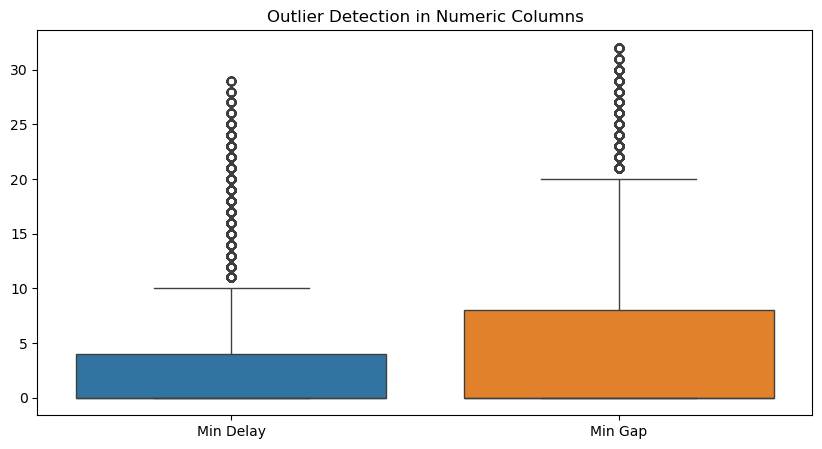

In [128]:
# Checking for outliers in Numeric Columns

# Boxplot to detect outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Min Delay", "Min Gap"]])
plt.title("Outlier Detection in Numeric Columns")
plt.show()


In [129]:
# As it can be seen from the boxplot, there are outliers in both "Min Delay" and "Min Gap" columns which can be removed

# Storing original dataset size before removing outliers
original_shape = df.shape

# Defining outlier threshold (remove top 1% extreme values)
min_delay_threshold = df["Min Delay"].quantile(0.99)
min_gap_threshold = df["Min Gap"].quantile(0.99)

# Counting outliers before removal
outliers_before = ((df["Min Delay"] > min_delay_threshold) | (df["Min Gap"] > min_gap_threshold)).sum()

# Printing count of outliers before removal
print(f"Total outliers in numeric columns before removal: {outliers_before}")

# Removing outliers (values above 99th percentile)
df_cleaned = df[(df["Min Delay"] <= min_delay_threshold) & (df["Min Gap"] <= min_gap_threshold)]

# Storing new dataset size after removal
new_shape = df_cleaned.shape

# Calculating how many outliers were removed
outliers_removed = original_shape[0] - new_shape[0]

# Print results
print(f"Removed outliers in 'Min Delay' and 'Min Gap' (above 99th percentile).")
print(f"Total outliers removed: {outliers_removed}")
print(f"Original dataset shape: {original_shape}")
print(f"Updated dataset shape: {new_shape}")

# Update the dataset
df = df_cleaned

Total outliers in numeric columns before removal: 1381
Removed outliers in 'Min Delay' and 'Min Gap' (above 99th percentile).
Total outliers removed: 1381
Original dataset shape: (135745, 17)
Updated dataset shape: (134364, 17)


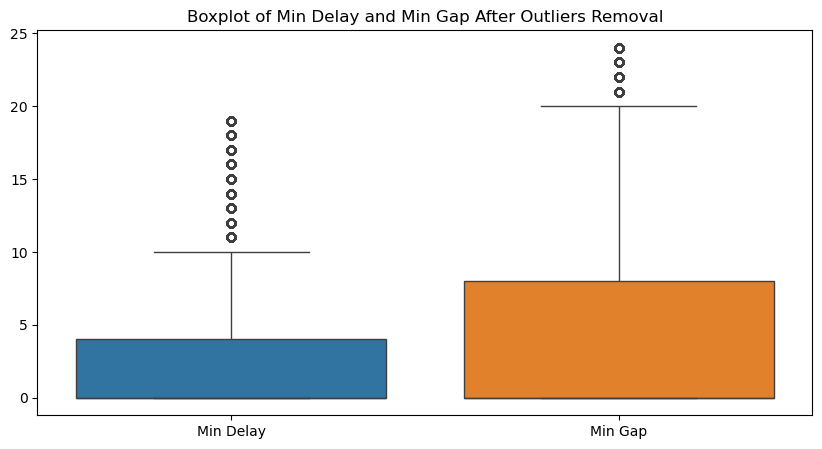

In [130]:
# Boxplot to visualize the distribution of "Min Delay" and "Min Gap" after outlier removal
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[["Min Delay", "Min Gap"]])
plt.title("Boxplot of Min Delay and Min Gap After Outliers Removal")
plt.show()

In [131]:
# Cleaning Date and Time Columns and Ensuring Correct Format

# Checking for missing values in "Date" and "Time"
date_missing = df["Date"].isnull().sum()
time_missing = df["Time"].isnull().sum()

# Printing the results
print(f"Missing values in 'Date': {date_missing}")
print(f"Missing values in 'Time': {time_missing}")

# No missing values in "Date" and "Time" columns so we can proceed

Missing values in 'Date': 0
Missing values in 'Time': 0


In [132]:
# Check for Invalid Dates (dataset starts from 2014 and ends at current date)

import datetime

# Define valid date range
min_valid_date = pd.Timestamp("2014-01-01")  # Start of dataset
max_valid_date = pd.Timestamp.today()        # Current date

# Count invalid dates
invalid_dates_count = df[(df["Date"] < min_valid_date) | (df["Date"] > max_valid_date)].shape[0]

# Print invalid dates count before removal
print(f"Total rows with invalid 'Date' values: {invalid_dates_count}")

# No invalid dates so we can proceed

Total rows with invalid 'Date' values: 0


Initial Descriptive Statistics

In [133]:
# Unique values in Station, Code, Bound and Line COlumns

# Count unique values in specified columns
unique_station_count = df["Station"].nunique()
unique_code_count = df["Code"].nunique()
unique_bound_count = df["Bound"].nunique()
unique_line_count = df["Line"].nunique()

# Print results
print(f"Unique 'Station' values: {unique_station_count}")
print(f"Unique 'Code' values: {unique_code_count}")
print(f"Unique 'Bound' values: {unique_bound_count}")
print(f"Unique 'Line' values: {unique_line_count}")


Unique 'Station' values: 159
Unique 'Code' values: 204
Unique 'Bound' values: 4
Unique 'Line' values: 14


In [134]:
# Descriptive statistics for "Min Delay" grouped by predictors

# Mean, Median, and Variance of "Min Delay" by "Time"
time_stats = df.groupby("Time")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Date"
date_stats = df.groupby("Date")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Station"
station_stats = df.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Bound"
bound_stats = df.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Line"
line_stats = df.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Mean, Median, and Variance of "Min Delay" by "Code"
code_stats = df.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Displaying the results
descriptive_stats = {
    "Descriptive Stats by Time": time_stats,
    "Descriptive Stats by Date": date_stats,
    "Descriptive Stats by Station": station_stats,
    "Descriptive Stats by Bound": bound_stats,
    "Descriptive Stats by Line": line_stats,
    "Descriptive Stats by Code": code_stats
}

# Display data tables
for name, stats in descriptive_stats.items():
    print(f"\n{name}:\n")
    print(stats.head(20))  # Displaying only first 20 rows of each stats table
    print("\n" + "-"*50)



Descriptive Stats by Time:

        Time      mean  median        var
0   00:00:00  3.650000     1.5  23.553390
1   00:01:00  3.432836     3.0  15.824966
2   00:02:00  3.093023     0.0  17.685363
3   00:03:00  4.244186     3.0  20.280848
4   00:04:00  3.229730     3.0  17.384857
5   00:05:00  3.203390     0.0  16.371712
6   00:06:00  2.925000     3.0  11.310759
7   00:07:00  3.319444     3.0  14.755673
8   00:08:00  3.694118     3.0  20.429132
9   00:09:00  3.194030     3.0  16.370873
10  00:10:00  3.263158     1.5  16.809825
11  00:11:00  3.304348     3.0  14.156010
12  00:12:00  2.394366     0.0  12.556539
13  00:13:00  3.149254     0.0  16.341022
14  00:14:00  3.027397     3.0  12.443683
15  00:15:00  2.823529     0.0  16.565408
16  00:16:00  3.430556     3.0  15.882433
17  00:17:00  2.820896     0.0  14.997739
18  00:18:00  3.000000     3.0  11.104478
19  00:19:00  3.603175     3.0  16.533538

--------------------------------------------------

Descriptive Stats by Date:

        

In [135]:
# Extracting year and month from "Date" for grouping
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Compute descriptive statistics for "Min Delay" on a yearly basis
yearly_stats = df.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Compute descriptive statistics for "Min Delay" on a monthly basis
monthly_stats = df.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Print results
print("\nDescriptive Stats by Year:\n", yearly_stats)
print("\nDescriptive Stats by Month:\n", monthly_stats)



Descriptive Stats by Year:
     Year      mean  median        var
0   2014  2.033576     0.0   9.716478
1   2015  1.560166     0.0   8.682933
2   2016  1.790577     0.0   9.731859
3   2017  1.969971     0.0  10.387594
4   2018  2.328961     0.0  10.860340
5   2019  2.368055     0.0  10.949610
6   2020  3.097138     3.0  11.134778
7   2021  3.265475     3.0  13.504062
8   2022  3.472867     3.0  14.861543
9   2023  3.320961     3.0  15.798711
10  2024  3.155088     3.0  15.025936
11  2025  5.858054     5.0  12.061289

Descriptive Stats by Month:
      Year  Month      mean  median        var
0    2014      1  2.425719     0.0  10.564422
1    2014      2  2.098195     0.0   8.653646
2    2014      3  2.031418     0.0   8.870945
3    2014      4  2.089302     0.0   9.250863
4    2014      5  2.040191     0.0   9.908345
..    ...    ...       ...     ...        ...
120  2024      9  3.152586     3.0  14.933557
121  2024     10  3.145485     3.0  14.599737
122  2024     11  3.059514     3.

In [136]:
# Dividing into Rush Hour and Non-Rush Hour
# Rush Hour data frame has been saved as df_rush and non-rush hour data frame has been saved as df_non_rush

# Ensure "Time" is a string and strip any unwanted characters
df["Time"] = df["Time"].astype(str).str.strip()

# Extract hour safely by splitting on ":" and taking the first part
df["Hour"] = df["Time"].apply(lambda x: int(x.split(":")[0]) if ":" in x and x.split(":")[0].isdigit() else None)

# Remove rows where "Hour" is missing or could not be extracted
df = df.dropna(subset=["Hour"])

# Define rush hour (Morning: 6-9 AM, Evening: 4-7 PM)
df["RushHour"] = df["Hour"].apply(lambda x: 1 if (6 <= x <= 9) or (16 <= x <= 19) else 0)

# Define non-rush hour (Opposite of Rush Hour)
df["NonRushHour"] = df["RushHour"].apply(lambda x: 1 if x == 0 else 0)

# Create separate dataframes for rush hour and non-rush hour
df_rush = df[df["RushHour"] == 1].copy()
df_non_rush = df[df["NonRushHour"] == 1].copy()

# Print first few rows of each dataframe to confirm
print("Rush Hour Data Sample:")
print(df_rush.head())

print("\nNon-Rush Hour Data Sample:")
print(df_non_rush.head())


Rush Hour Data Sample:
         Date      Time        Day             Station   Code  Min Delay  \
12 2014-01-01  08:48:00  Wednesday     kipling station  munoa        5.0   
13 2014-01-01  08:49:00  Wednesday   yonge shp station  munoa        6.0   
14 2014-01-01  08:53:00  Wednesday  st patrick station   tusc        0.0   
15 2014-01-01  08:55:00  Wednesday   yonge shp station  munoa       12.0   
16 2014-01-01  08:58:00  Wednesday  kennedy bd station  munoa        5.0   

    Min Gap Bound Line Vehicle  Year  Month  DayOfWeek  DayOfMonth  Hour  \
12      0.0     e   bd     0.0  2014      1          2           1     8   
13     12.0     e  shp  5276.0  2014      1          2           1     8   
14      0.0     s   yu  5611.0  2014      1          2           1     8   
15     18.0     e  shp  5282.0  2014      1          2           1     8   
16     10.0     w   bd     0.0  2014      1          2           1     8   

    RushHour  NonRushHour  
12         1            0  
13     

In [137]:
# Count unique values
unique_station_count_rush = df_rush["Station"].nunique()
unique_code_count_rush = df_rush["Code"].nunique()
unique_bound_count_rush = df_rush["Bound"].nunique()
unique_line_count_rush = df_rush["Line"].nunique()

unique_station_count_non = df_non_rush["Station"].nunique()
unique_code_count_non = df_non_rush["Code"].nunique()
unique_bound_count_non = df_non_rush["Bound"].nunique()
unique_line_count_non = df_non_rush["Line"].nunique()

# Print results
print("Rush Hour Data:")
print(f"Unique 'Station' values: {unique_station_count_rush}")
print(f"Unique 'Code' values: {unique_code_count_rush}")
print(f"Unique 'Bound' values: {unique_bound_count_rush}")
print(f"Unique 'Line' values: {unique_line_count_rush}")

print("\nNon-Rush Hour Data:")
print(f"Unique 'Station' values: {unique_station_count_non}")
print(f"Unique 'Code' values: {unique_code_count_non}")
print(f"Unique 'Bound' values: {unique_bound_count_non}")
print(f"Unique 'Line' values: {unique_line_count_non}")

Rush Hour Data:
Unique 'Station' values: 121
Unique 'Code' values: 194
Unique 'Bound' values: 4
Unique 'Line' values: 5

Non-Rush Hour Data:
Unique 'Station' values: 132
Unique 'Code' values: 197
Unique 'Bound' values: 4
Unique 'Line' values: 13


In [138]:
# Descriptive statistics for "Min Delay" on rush hour data grouped by predictors
rush_station_stats = df_rush.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_bound_stats = df_rush.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_line_stats = df_rush.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_code_stats = df_rush.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
rush_day_stats = df_rush.groupby("Day")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on non-rush hour data grouped by predictors
non_rush_station_stats = df_non_rush.groupby("Station")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_bound_stats = df_non_rush.groupby("Bound")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_line_stats = df_non_rush.groupby("Line")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_code_stats = df_non_rush.groupby("Code")["Min Delay"].agg(["mean", "median", "var"]).reset_index()
non_rush_day_stats = df_non_rush.groupby("Day")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Print results for Rush Hour
print("\nDescriptive Stats for Rush Hour by Station:\n", rush_station_stats.head(10))
print("\nDescriptive Stats for Rush Hour by Bound:\n", rush_bound_stats)
print("\nDescriptive Stats for Rush Hour by Line:\n", rush_line_stats)
print("\nDescriptive Stats for Rush Hour by Code:\n", rush_code_stats.head(10))
print("\nDescriptive Stats for Rush Hour by Day:\n", rush_day_stats)

# Print results for Non-Rush Hour
print("\nDescriptive Stats for Non-Rush Hour by Station:\n", non_rush_station_stats.head(10))
print("\nDescriptive Stats for Non-Rush Hour by Bound:\n", non_rush_bound_stats)
print("\nDescriptive Stats for Non-Rush Hour by Line:\n", non_rush_line_stats)
print("\nDescriptive Stats for Non-Rush Hour by Code:\n", non_rush_code_stats.head(10))
print("\nDescriptive Stats for Non-Rush Hour by Day:\n", non_rush_day_stats)



Descriptive Stats for Rush Hour by Station:
                   Station      mean  median        var
0        bathurst station  2.723827     0.0  13.596285
1             bay station  3.350242     3.0  15.860085
2         bayview station  2.715909     0.0  13.245982
3       bessarion station  3.333333     3.0  15.576471
4           birchmount ee  0.000000     0.0        NaN
5   bloor danforth subway  0.300000     0.0   0.900000
6           bloor station  1.975195     0.0   9.659311
7  broadview and danforth  0.000000     0.0        NaN
8       broadview station  2.928371     3.0  13.669968
9              buchan esb  0.000000     0.0        NaN

Descriptive Stats for Rush Hour by Bound:
   Bound      mean  median        var
0     e  2.163564     0.0  10.616178
1     n  2.731157     0.0  13.249133
2     s  2.710193     3.0  10.511533
3     w  2.139669     0.0  10.391282

Descriptive Stats for Rush Hour by Line:
       Line      mean  median        var
0  35 jane  0.000000     0.0        N

In [140]:
# Descriptive Statistics for "Min Delay" by Rush Hour and Non-Rush Hour (Yearly and Monthly)

# Descriptive statistics for "Min Delay" on a yearly basis for rush hour data
rush_yearly_stats = df_rush.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a monthly basis for rush hour data
rush_monthly_stats = df_rush.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a yearly basis for non-rush hour data
non_rush_yearly_stats = df_non_rush.groupby("Year")["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Descriptive statistics for "Min Delay" on a monthly basis for non-rush hour data
non_rush_monthly_stats = df_non_rush.groupby(["Year", "Month"])["Min Delay"].agg(["mean", "median", "var"]).reset_index()

# Print results for Rush Hour
print("\nDescriptive Stats for Rush Hour by Year:\n", rush_yearly_stats)
print("\nDescriptive Stats for Rush Hour by Month:\n", rush_monthly_stats.head(20))

# Print results for Non-Rush Hour
print("\nDescriptive Stats for Non-Rush Hour by Year:\n", non_rush_yearly_stats)
print("\nDescriptive Stats for Non-Rush Hour by Month:\n", non_rush_monthly_stats.head(20))



Descriptive Stats for Rush Hour by Year:
     Year      mean  median        var
0   2014  1.996750     0.0   9.122330
1   2015  1.448334     0.0   7.636325
2   2016  1.701590     0.0   8.657212
3   2017  1.761464     0.0   8.972856
4   2018  2.218638     0.0   9.788296
5   2019  2.226341     0.0   9.918187
6   2020  3.041296     3.0  10.217686
7   2021  3.196214     3.0  12.497626
8   2022  3.472458     3.0  13.909471
9   2023  3.257017     3.0  13.748292
10  2024  3.209639     3.0  14.385252
11  2025  5.814394     4.0  13.011047

Descriptive Stats for Rush Hour by Month:
     Year  Month      mean  median        var
0   2014      1  2.310030     0.0   9.851984
1   2014      2  2.074965     0.0   7.859811
2   2014      3  2.007692     0.0   8.337383
3   2014      4  2.103896     0.0   9.569111
4   2014      5  1.788650     0.0   7.590538
5   2014      6  1.983640     0.0   8.843994
6   2014      7  2.106262     0.0   8.730132
7   2014      8  1.715808     0.0   7.335461
8   2014      

Initial Data Exploration

In [ ]:
# Summary Statistics
print(df.describe(include="all"))
